#         Machine Learning in Python & Hands-on Training

We are going to perform drone imagery classification on the training dataset for crop types in Rwanda.

The dataset contains 2606 crop type images with 6 labels classified as:

 "banana",
                    "maize",
                    "other",
                    "forest",
                    "legumes",
                    "structure"
                    
The aim of this tutorial is to:
1. Obtain the data from Radiant Earth's python client successfully
2. Extract this data and process it to a better form to build the ML model
3. Training and evaluating the model
4. Transfer learning using the test data

## Obtaining the Data

To achieve the first, we will have to install radiant's MLhub library using pip.

**NOTE:** Make sure Jupyter notebook is run with administrative privileges or the installation could fail.

The documentation of the library is available at: https://radiant-mlhub.readthedocs.io/en/latest/getting_started.html#installation

We will need an API key to implement the library.
To obtain that:
1. Sign up on MLHub and generate an API key (steps are available in the documentation referenced earlier)
2. Use the following on the Anaconda prompt or command line: 'mlhub configure'

The command prompt diplays the following message:

'API Key: Enter your API key here...'

3. Copy and paste the API key generated earlier

Wrote profile to C:\Users\Maximus\.mlhub\profiles

In [8]:
#let's view the datasets contained in the data registry
from radiant_mlhub import Dataset, Collection #Collection module will be used for viewing collection ids
for dataset in Dataset.list():
    print(f'{dataset.id:<32}: {dataset.title}')

idiv_asia_crop_type             : A crop type dataset for consistent land cover classification in Central Asia
bigearthnet_v1                  : BigEarthNet
microsoft_chesapeake            : Chesapeake Land Cover
ref_african_crops_kenya_02      : CV4A Kenya Crop Type Competition
ref_african_crops_uganda_01     : Dalberg Data Insights Crop Type Uganda
rti_rwanda_crop_type            : Drone Imagery Classification Training Dataset for Crop Types in Rwanda
ref_african_crops_tanzania_01   : Great African Food Company Crop Type Tanzania
landcovernet_v1                 : LandCoverNet
open_cities_ai_challenge        : Open Cities AI Challenge
ref_african_crops_kenya_01      : PlantVillage Crop Type Kenya
su_african_crops_ghana          : Semantic Segmentation of Crop Type in Ghana
su_african_crops_south_sudan    : Semantic Segmentation of Crop Type in South Sudan
sen12floods                     : SEN12-FLOOD
ts_cashew_benin                 : Smallholder Cashew Plantations in Benin
spacenet1  

We are going to use rti rwanda crop type here

In [2]:
dataset = Dataset.fetch('rti_rwanda_crop_type')
dataset.collections #viewing the collection ids under the crop type dataset

[<Collection id=rti_rwanda_crop_type_labels>, <Collection id=rti_rwanda_crop_type_source>, <Collection id=rti_rwanda_crop_type_raw>]

The dataset consists of:

1. Collection id = rti_rwanda_crop_type_labels 

2. Collection id = rti_rwanda_crop_type_source

3. Collection id = rti_rwanda_crop_type_raw

In this exercise, we will use only the first two collections.

Source collection id consists of the images that are to be trained in ML while

Labels collection id consists of the tags/classes/labels to the images.

We will download both of them by first 'fetching' their contents, then 'downloading' them to the local system. The Collection module once again, provides the packages needed.
For this tutorial, we will use the 'Downloads' folder for data storage and access.

In [4]:
collection = Collection.fetch('rti_rwanda_crop_type_labels')#downloading the labels
collection.download('~/Downloads/Data')  # Will raise exception if the file already exists

  0%|          | 0/0.8 [00:00<?, ?M/s]

In [5]:
collection = Collection.fetch('rti_rwanda_crop_type_source') #downloading the source images
collection.download('~/Downloads/Data')   # Will raise exception if the file already exists

  0%|          | 0/104.5 [00:00<?, ?M/s]

## Extracting the data

The data is then extracted into an "Extracted" folder.

What we'll do next is to match each label to the respective image it points to.

To do this, we will create a list that will contain the addresses of each of the labels called "source".
There will also be a list containing the addresses of each of the source images called "destination".



In [6]:
from pathlib import Path
downloads_path = str(Path.home() / "Downloads") #making a relative path wrt the Downloads folder

In [7]:
import os #to access the files on the local system
labels = downloads_path+ "\\Extracted\\rti_rwanda_crop_type_labels" #label files
sources = downloads_path + "\\Extracted\\rti_rwanda_crop_type_source" #source image files
label = []
for x in os.walk(labels): #access each file location in the labels' folder
    label.append(x[0]) #add them to the list
print(label[0])
label.pop(0) #it includes the labels' folder by default. need to remove it from the list as it does not belong
print(label[1]) #let's see an example of the file location
print(len(label)) #how many labels are there?

source = []
for y in os.walk(sources): #access each file location in the source images' folder
    source.append(y[0]) #add them to the list
source.pop(0) #includes the source images' folder by default. need to remove it from the list as it doesn't belong
print(source[1]) #an example of the file location
print(len(source)) #how many images are there? the number should match with that of the number of labels

C:\Users\Maximus\Downloads\Extracted\rti_rwanda_crop_type_labels
C:\Users\Maximus\Downloads\Extracted\rti_rwanda_crop_type_labels\rti_rwanda_crop_type_labels_1
2606
C:\Users\Maximus\Downloads\Extracted\rti_rwanda_crop_type_source\rti_rwanda_crop_type_source_1
2606


The code below then matches and copies the labels to the source images.

**NOTE THAT :** Python sorts the folder lexicographically.

That is, 
- rti_rwanda_crop_type_labels_1
- rti_rwanda_crop_type_labels_10
- rti_rwanda_crop_type_labels_11
where 1 represents the first label, 10 represents the 10th label, 11 represents the 11th label, etc.

Similarly, the source images will be sorted thus:
- rti_rwanda_crop_type_source_1
- rti_rwanda_crop_type_source_10
- rti_rwanda_crop_type_source_11
where 1 represents the first image, 10 represents the 10th image, 11 represents the 11th image, etc.

All we then need to do is to make a for loop for each label to be added to its respective image i.e assign first label to first image, 10th label to 10th image, etc.


In [8]:
import shutil #for copying files from one folder to another
for i in range (0,2606): #2606 images and labels
    src_files = os.listdir(label[i])
    for file_name in src_files:
        full_file_name = os.path.join(label[i], file_name) #complete file path
        if os.path.isfile(full_file_name): #if the path exists (double-checks)
            shutil.copy(full_file_name, source[i]) #copy to the source image folder

In [9]:
folder = sources #prepared folder. same as the source images folder

In [10]:
import os
source = []
for x in os.walk(folder): #accessing the modified (source + label) files in the folder
    source.append(x[0])
    
source.pop(0) #removing the irrelevant folder detail as we did earlier

'C:\\Users\\Maximus\\Downloads\\Extracted\\rti_rwanda_crop_type_source'

In [12]:
import json # import json module for parsing

# define a list of keywords based on the label classes ()
keywords = (
                   "banana",
                    "maize",
                    "other",
                    "forest",
                    "legumes",
                    "structure"
)
  
for i in range (0,2606):
    label = source[i]+'\labels.json' #we are only concerned about the labels.json, not stac.json
    with open(label) as json_file:
        # read json file line by line
        for line in json_file.readlines():
            # create python dict from json object
            json_dict = json.loads(line)
            
            if any(keyword in json_dict["label"].lower() for keyword in keywords):
                 #checking the keyword tag for that particular label
                folder_name = json_dict["label"] #contains the label tag
                images = source[i] +'\image.png'
                '''
                We want to copy the images to a separate folder "Images"
                This folder will contain the list of label tags as a folder and the images contained in the tag
                
                '''
                dest_path = downloads_path + '\\Images'
                dest_folder = dest_path + "\\" + folder_name #folder name wrt to the label

                if os.path.isfile(images):   #checking if image.png is there, rather than removing manually 
                    if not os.path.exists(dest_folder): #if class folder doesn't exist, create it
                        os.mkdir(dest_folder)
                        
                    j = 0  #we'll use this for renaming files of the same name (images)
                    name = 'image' #name of the image
                    extension ='.png' #its file extension
                    
                    #rename the image file to avoid overwriting each (since they have the same name)
                    dest_filename = os.path.join(dest_folder, "%s%d%s" % (name, j,     extension))  #regex
                    while os.path.isfile(dest_filename): #while the image file has been created in the destination folder                                  
                        j += 1                                                                                                                      
                        dest_filename = os.path.join(dest_folder, "%s%d%s" % (name, j, extension))
                    shutil.copy(images, dest_filename) #finally copying as renaming has been taken care of   
                    

Note that the labels and more details on the data are available in the documentation at the _common/documentation.pdf file which was extracted earlier

##  Machine Learning Preparation

We'll need to install tensorflow and tensorflow_hub.

Let us also import the needed libraries. Notes on these libraries are commented in the code

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals #for newer features of python
import matplotlib.pylab as plt #graphical plots
import tensorflow as tf #deep learning
import tensorflow_hub as hub
import numpy as np #numerical procedures
import pandas as pd #data handling

In [226]:
tf.version.VERSION #tensorflow version used here

'2.4.1'

In [14]:
pd.set_option("display.precision", 6) #setting display precision

In [15]:
data_root=downloads_path + '\\Images' #access to the data on local system

For building the model, we will also need keras for the convolutional layers, hence keras must be installed and thereafter, imported

In [16]:
#importing everything related to keras and building the model
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

#after building the model, we will make use of these for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import itertools #for iterations
import time #for saving the model with respect to the system time 

For this case, we're going to use a multi-class model. We will use the following classes:
- banana
- forest
- legumes
- maize
- other
- structure

The other images are excluded from the "Images" folder.

In [17]:
selectedClasses = (os.listdir(data_root)) #displaying the path and folders available
print (selectedClasses) #classes from the Images folder

['banana', 'forest', 'legumes', 'maize', 'other', 'structure']


We have < 2606 images across the folders. These may not be enough to train the model appropriately.
Hence, to make more images available for training, we will apply *data augmentation.*

Data augmentation, in data science are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

Data augmentation is applied below with comments:

In [103]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20) #rescale is normalisation for numerical stability and convergence
train_datagen = ImageDataGenerator(
    **datagen_kwargs,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False) 

For the data augmentation, i choose to :

Randomly rotate some training images by 10 degrees

Randomly Zoom by 10% some training images

Randomly shift images horizontally by 10% of the width

Randomly shift images vertically by 10% of the height

Documentation is available at: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Once our model is ready, we fit the training, validation and test dataset below

In [104]:
TRAINING_DATA_DIR = str(data_root) #data directory for training
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    target_size=(224, 224), #image size
    shuffle = True, #randomize the data for training
    subset='training') # set as training data

#validation data is just a subset of training data, hence, we use train_datagen for the validation generator too
validation_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, # same directory as training data
    target_size=(224, 224),
    shuffle = True,
    subset='validation') # set as validation data

Found 2087 images belonging to 6 classes.
Found 519 images belonging to 6 classes.


Since we do not have abundant data here, we will create the test data based on the available data.

We selected the test data to be 30% of the data. 15% or 20% are more common splits.

The test data will thus share some data with the validation data but not all, since the validation data is randomised

In [195]:
datagen_kwargs = dict(rescale=1./255,validation_split=.3) #for  the test data. 30% of training data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=False,
target_size=(224,224)
)

Found 779 images belonging to 6 classes.


We want to plot some samples of the images in the dataset. However, we will need to instantiate a duplicate train_generator, but without the normalisation.

This is because, with normaliation, the ouput sample images will just be a list of dark images without any identity in this case.

The duplicate is initialised as 'train_generator_plot'.

In [165]:
train_datagen_plot = ImageDataGenerator()
train_generator_plot = train_datagen_plot.flow_from_directory(
    TRAINING_DATA_DIR,
    target_size=(224, 224), #image size
    shuffle = True, #randomize the data for training
    subset='training')

Found 2606 images belonging to 6 classes.


In [196]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
    #displaying item number for train_generator
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
    #displaying item number for train_generator
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(test_generator.classes).count(cls))
    #displaying item number for train_generator

In train_generator 
banana :	 351
forest :	 520
legumes :	 152
maize :	 623
other :	 308
structure :	 133

In validation_generator 
banana :	 87
forest :	 129
legumes :	 38
maize :	 155
other :	 77
structure :	 33

In test_generator 
banana :	 131
forest :	 194
legumes :	 57
maize :	 233
other :	 115
structure :	 49


We will randomly plot images just to quickly inspect

In [23]:
#plots images with labels within jupyter notebook
def plots(ims, figsize = (10,10), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')  

In [167]:
train_generator_plot.reset()
imgs, labels = train_generator_plot.next() #assign the images you want to plot in here

#print(labels)

labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]
#print(labelIndices)

for ind in labelIndices:
    for labelName,labelIndex in train_generator.class_indices.items():
        if labelIndex == ind:
            #print (labelName)
            labelNames.append(labelName)

#labels

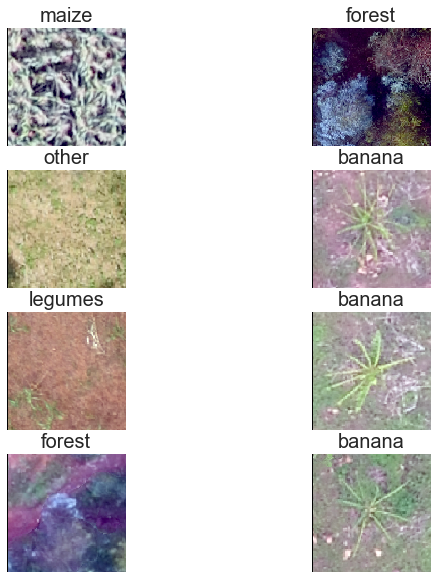

In [168]:
plots(imgs, rows=4, titles = labelNames, maxNum=8)

We will begin building and training the model soon, but first, we need to initialize a filepath where the model gets repeatedly updated as the validation accuracy increases.

In [107]:
#Automatic rename with epoch number and val accuracy:
#filepath="checkpoints/weights-improvement-epeoch-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"


 
modelName= "Model"
#save the best weights over the same file with the model name

#filepath="checkpoints/"+modelName+"_bestweights.hdf5"
filepath=modelName+"_bestweights.hdf5" #it is in the same folder as where the notebook is
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max') #max validation accuracy
callbacks_list = [checkpoint]

We will build the model next. We have the following model choices:

* **The simple Convolution Neural Network (CNN)** is especially useful for binary image classification and simple multiclass cases.
However, some drawbacks include classification of images with different positions. It also requires a large dataset to process and train the neural network, which we do not have the abundance of in this case. It could also be slow at times.


* **RESNET**, another option makes it possible to train up to hundreds or even thousands of layers and still achieves compelling performance. It however, has increased complexity of architecture and could be time-consuming, especially without a GPU in this case.


* **VGG** is a very good architecture for benchmarking on a particular task with high accuracy.


* The model we're using is **Tensorflow's Mobilenet_V2 model** based on ImageNet.
It is a very handy deep learning model because it is a small, low-latency convolutional neural network.
It has about the same accuracy as VGG but MobileNet is about 32 times smaller than VGG (VGG16), yet has the same accuracy, it must be more efficient at capturing knowledge than VGG is. It's indeed a known fact that VGG has way more connections than it needs in order to do its job.
It's also quite fast and accurate, while having a relatively portable size (14mb), which is the smallest of all Deep Convolutional Neural Network Architectures.


* **InceptionV3 and Xception** are also very efficient models. They have better accuracies than Mobilenet but are larger, more complex and would require GPU to train models without causing the system to hang/fail. 

Documentation for MobileNetV2 is available at: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4

## Building the Model

In [108]:
#getting the MobileNet model from TensorFlow
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4), #prevent a model from overfitting
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax') #works on the input and returns the output
#Softmax is often used as the activation for the last layer of a classification network
#because the result could be interpreted as a probability distribution
])
model.build([None, 224, 224, 3]) #based on the input shape we specified earlier
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy', #for multi-class
metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [109]:
batchSize=32 #default practice
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch) #formula

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps) #formula


#validationSteps=(test_generator.samples+ (batchSize-1)) // batchSize
#print("validationSteps: ", validationSteps)

stepsPerEpoch:  66
validationSteps:  17


Epoch represents each instance the model trains. stepsPerEpoch represents the number of steps the model takes to evaluate itself for each epoch with respect to the training data.

validationSteps is the stepsPerEpoch, but for the validation data.

## Training and Evaluating the Model

In [110]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs = 30, #just a significant number
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/30
66/66 [==============================] - 156s 2s/step - loss: 1.8145 - acc: 0.3743 - val_loss: 0.9297 - val_acc: 0.6879

Epoch 00001: val_acc improved from -inf to 0.68786, saving model to Model_bestweights.hdf5
Epoch 2/30
66/66 [==============================] - 146s 2s/step - loss: 1.0364 - acc: 0.6341 - val_loss: 0.8242 - val_acc: 0.6936

Epoch 00002: val_acc improved from 0.68786 to 0.69364, saving model to Model_bestweights.hdf5
Epoch 3/30
66/66 [==============================] - 145s 2s/step - loss: 0.8966 - acc: 0.6720 - val_loss: 0.8199 - val_acc: 0.7129

Epoch 00003: val_acc improved from 0.69364 to 0.71291, saving model to Model_bestweights.hdf5
Epoch 4/30
66/66 [==============================] - 144s 2s/step - loss: 0.8689 - acc: 0.6963 - val_loss: 0.7322 - val_acc: 0.7110

Epoch 00004: val_acc did not improve from 0.71291
Epoch 5/30
66/66 [==============================] - 145s 2s/step - loss: 0.7909 - acc: 0.7114 - val_loss: 0.8171 - val_acc: 0.6821

Epoch 00005

We obtained a peak validation accuracy of 80.5%, which is good enough in this case.

We will then plot the accuracy and loss graphs for the model.

In [111]:
def plot_details(train):  
  plt.figure(figsize=[10,7]) #setting figure size
  plt.plot(train.history['acc'],'r',linewidth=3.0) #first line for training accuracy
  plt.plot(train.history['val_acc'],'b',linewidth=3.0) #second line for validation accuracy
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

  # Loss Curves
  plt.figure(figsize=[10,7]) 
  plt.plot(train.history['loss'],'r',linewidth=3.0) #training loss
  plt.plot(train.history['val_loss'],'b',linewidth=3.0) #validation loss
  plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

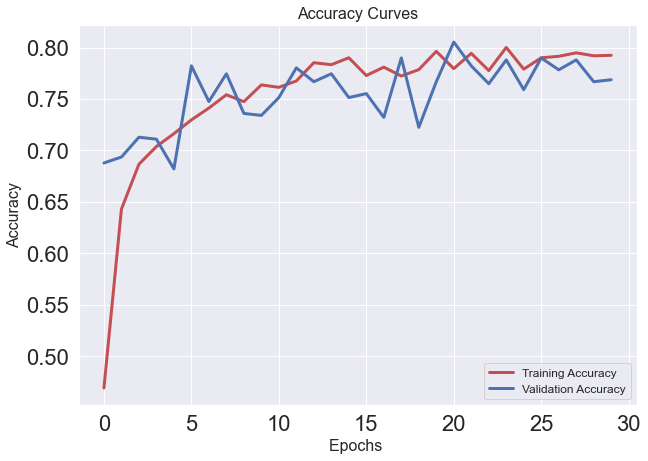

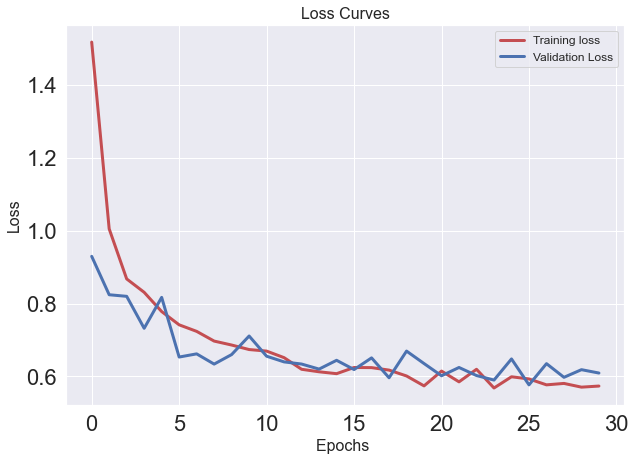

In [113]:
plot_details(history)

# Transfer Learning

The process will be thus:
* Save the model and the weights for the neural-network.
* Then, the model and its best weights are uploaded. That is, the model is treated as a new model being applied to a new process. This is the process of **transfer learning**.
* The model is setup as it attempts to predict the fresh test dataset, which has been independent of the training and parameter tuning done earlier.
* The model is evaluated against the test dataset. Its accuracy for the test-set will be checked. The precision for every class will also be checked as well as the confusion matrix graph. These will help us understand the application of the model from a practical perspective.

## Save the Model and Last Weights

In [116]:
timestr = time.strftime("%Y%m%d_%H%M%S")

# serialize model to JSON
model_json = model.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")

## Upload the Model and Best Weights

In [117]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('20210430_112038_Model_MODEL_3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, custom_objects={'KerasLayer': hub.KerasLayer})

In [118]:
# load weights into new model
model.load_weights("Model_bestweights.hdf5")

## Setting up Model to Work on Test Set of Images

We initialized the 'predictions' variable. This will store the model's predictions on the test set.

It took 50 seconds to make 779 predictions, showing the time-effectiveness of the model.

In [197]:
test_generator.reset()
testStep = (test_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  25
25/25 [==============================] - 50s 2s/step


779

In [220]:
predicted_class_indices=np.argmax(predictions,axis=1)

We stored a 'y_pred' variable. This will contain the predicted results in an array format for numerical data calculations.

It is shown as a numpy array type.

In [221]:
y_pred=model.predict_classes(test_generator)

In [222]:
type(y_pred)

numpy.ndarray

Similarly, 'y_true' represents the actual class of the image to be predicted.

In [218]:
y_true=np.array(test_generator.classes)
y_true = y_true.astype(np.int64)

In [211]:
labels = (test_generator.class_indices) #displaying the labels/classes of the test set

In [212]:
labels = dict((v,k) for k,v in labels.items()) #converting to a dictionary, which is more efficient

In [213]:
actualLables= [labels[k] for k in test_generator.classes] #actual labels

In [214]:
predictedLables= [labels[k] for k in predicted_class_indices] #predicted labels

## Evaluating the Model's Performance on the Test Data

The first step taken is evaluating the accuracy.
Accuracy represents the rate at which the model classifies an image correctly.

#### * In this case, accuracy represents the model's efficiency in correctly classifying a crop image

In [223]:
accuracy_score(actualLables, predictedLables) #evaluating the accuracy

0.7086007702182285

### ACCURACY: 71%

A decent accuracy of 70.86% ≈ 71% was obtained. This indicates a good performance of the model, given available data.

However, evaluating the accuracy is not sufficient. We need to determine other parameters such as precision and recall.

### The precision and recall metrics

https://en.wikipedia.org/wiki/Precision_and_recall

Several metrics can be derived from a confusion matrix. (See the Wikipedia article.) In particular, they tend to be based on the special case of a confusion matrix, where we assign one class to be the "positive" class that is important to us. This is sometimes called a table of confusion. In such a table, we speak of true positives, false positives, false negatives, and true negatives.

The precision and recall metrics are probably the most common metrics derived from such a table.

**Precision (P) = TP / (TP + FP)**

**Recall (R) = TP / (TP + FN)**

When a search engine returns 30 pages, only 20 of which are relevant, while failing to return 40 additional relevant pages, its precision is 20/30 = 2/3, which tells us how valid the results are, while its recall is 20/60 = 1/3, which tells us how complete the results are.

For example, What's the precision and recall of 'banana' in this case?

The utility function classification_report prints the precision and recall values for all the categories. (The F1 score combines the precision and recall values into a single value.)

In [219]:
import sklearn.metrics as metrics
report = metrics.classification_report(y_true, y_pred, target_names=selectedClasses)
print(report)   #displaying the results
#f1-score is a measure of the test's accuracy

              precision    recall  f1-score   support

      banana       0.91      0.81      0.85       131
      forest       0.59      0.94      0.72       194
     legumes       0.40      0.44      0.42        57
       maize       0.92      0.66      0.77       233
       other       0.58      0.42      0.48       115
   structure       0.95      0.73      0.83        49

    accuracy                           0.71       779
   macro avg       0.72      0.67      0.68       779
weighted avg       0.75      0.71      0.71       779



We can see that the model does best in evaluating classes 'banana', 'maize' and 'structure', but not very well with 'legumes' and 'other'.

In [224]:
recall_score( actualLables, predictedLables,average='weighted')

0.7086007702182285

### Recall score: 0.71

This is a decent score. A perfect recall score is 1, hence our recall score and the model are great.

In [228]:
precision_score( actualLables, predictedLables,average='weighted') 

0.7487104561836078

### Precision score: 0.75

This is a very impressive score. A perfect precision score is 1, hence our precision score is great and the model is fine.

### Visualising the confusion matrix

The confusion matrix gives a very good visual of the accuracy, precision and recall.

It also helps us see the details of each crop-type classification, which class was most incorrectly evaluated for each item, etc.

In summary, it gives a good intuition of the data and its classification.

[Text(146.5, 0.5, 'True labels'),
 Text(0.5, 146.5, 'Predicted labels'),
 Text(0.5, 1.0, 'Confusion Matrix')]

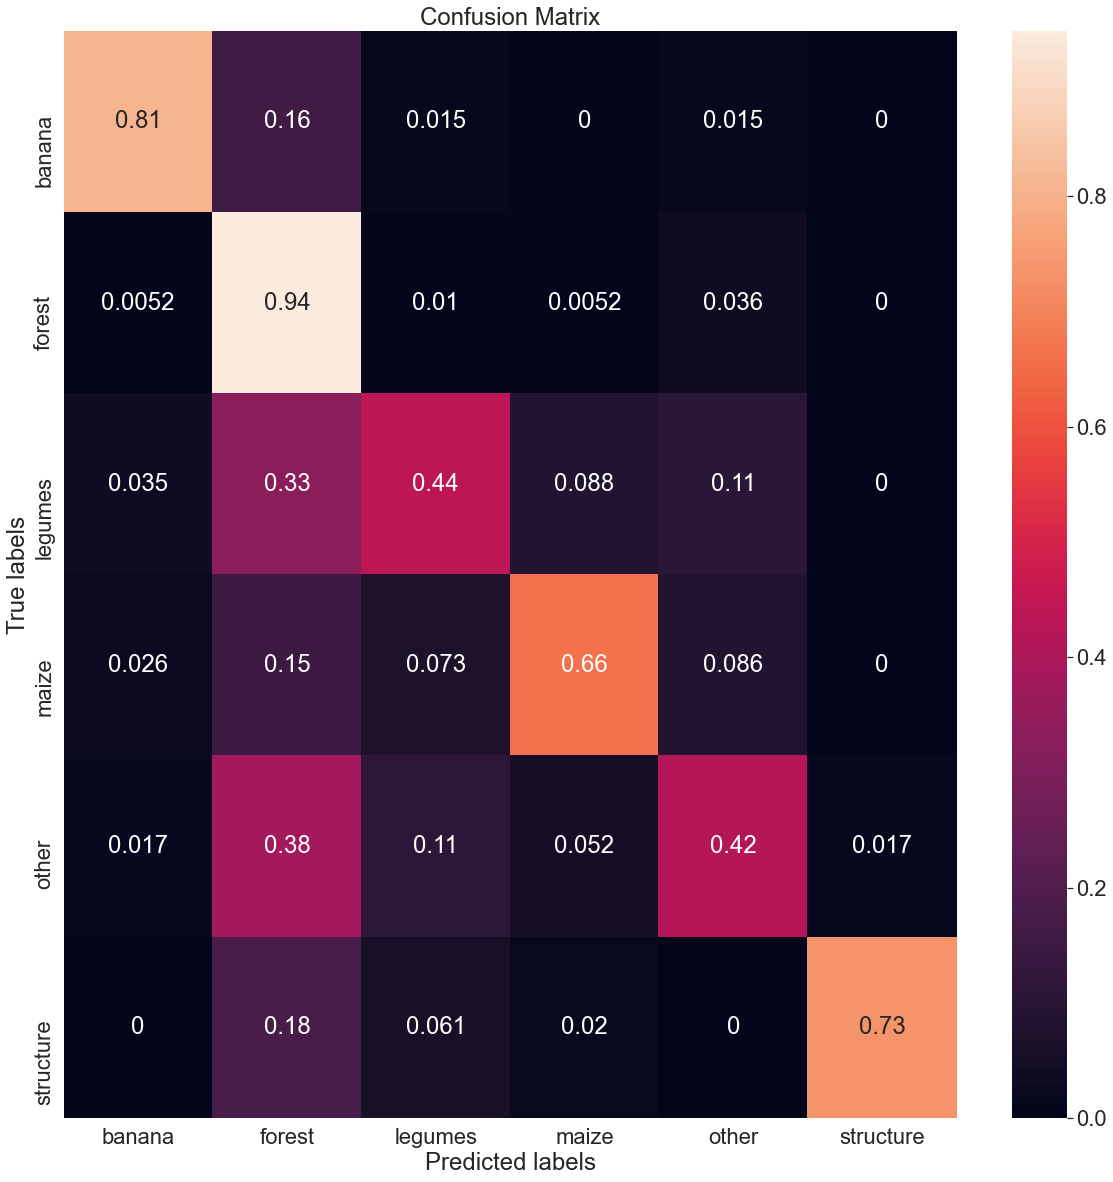

In [232]:
#seaborn module will be used to visualize the confusion matrix
import seaborn as sn 
cm = metrics.confusion_matrix(y_true, y_pred) #initialising the confusion matrix 'cm'

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (20,20)) #setting an appropriate and legible diagram size
sn.set(font_scale=2) #increasing font for legibility
# Labels, title and ticks
ax=sn.heatmap(cmn, xticklabels = selectedClasses, yticklabels = selectedClasses, annot=True)
ax.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix')

We can see the highlighted results for the actual class vs the predicted class is weighted in terms of its recall.

This is because it combines the true positive and the total false negatives on the horizontal axis with the total being 1 (100%).

The precision rather combines the true positive and false positive for each class on the vertical axis.

The aim and objectives of the tutorials have been successfully completed.